In [1396]:
import numpy as np
import random
from dataclasses import dataclass
from tqdm.auto import tqdm
from typing import List
import itertools
None

In [1397]:
problem = np.load('../data/problem_7.npz')
X = problem['x']
Y = problem['y']

DATA = X
LABELS = Y

print(DATA.shape)
print(LABELS.shape)
print(DATA[:,0])
print(LABELS[0])
PROBLEM_SIZE = DATA.shape[0]

NUM_TOURNAMENTS = PROBLEM_SIZE*20
if NUM_TOURNAMENTS == 0:
    NUM_TOURNAMENTS= 1
    
POPULATION_SIZE = PROBLEM_SIZE*20*NUM_TOURNAMENTS
OFFSPRING_SIZE = int((POPULATION_SIZE//NUM_TOURNAMENTS)*0.8)
MAX_GENERATIONS = 4000

TOURNAMENT_GENERATIONS = 50
INCREASE_COMPLEXITY_STEP = 500
# Problem size can be maximum 3 terms more then starting complexity
PROBLEM_COMPLEXITIES = [PROBLEM_SIZE+i for i in range(5)]
# higher complexity is less probable to be initially generated
PROBLEM_COMPLEXITIES_WEIGHTS = [PROBLEM_COMPLEXITIES[len(PROBLEM_COMPLEXITIES)-i-1]/sum(PROBLEM_COMPLEXITIES) for i in range(len(PROBLEM_COMPLEXITIES))]

(2, 5000)
(5000,)
[0.19267392 1.98111504]
4.886874543831234


In [1398]:
rng = np.random.Generator(np.random.PCG64(42))

In [1399]:
# Operators

BINARY_OPERATORS = ["+", "-", "*", "/"]
UNARY_OPERATORS = ["sin", "cos","tan", "exp", "log","arcsin","arccos","arctan","sqrt","abs","reciprocal"]
VARIABLES = ["X_"+str(i) for i in range(PROBLEM_SIZE)]
VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {var: i for i,var in enumerate(VARIABLES)}

In [1400]:
@dataclass
class Individual:
    genome: list
    fitness: tuple

In [1401]:
def compute_MSE(Y_pred, Y_real):
    
    MSE = 100*np.square(Y_real-Y_pred).sum()/len(Y_real)
    return MSE

In [1402]:
def compute_unary_weights(unary_operators,j,x,y):
    """
    Compute unary operators weights depending on functions dominion and relation between input and output
    """
    W = {op: 0 for op in unary_operators}

    # Funzioni di dominio
    def is_valid_tan(x,curr):
        return np.abs(np.cos(x)) > 1e-9 and curr != -1

    def is_valid_log(x,curr):
        return x > 0 and curr != -1

    def is_valid_sqrt(x,curr):
        return x >= 0 and curr != -1
    
    def is_valid_reciprocal(x,curr):
        return x !=0 and curr != -1

    def is_valid_arcsin_arccos(x,curr):
        return -1 <= x <= 1 and curr != -1

    for i in range(x.shape[1]):  # Per ogni riga di x
        curr_x = x[j, i]
        curr_y = y[i]

        for op in unary_operators:
            if op == "sin" or op == "cos":
                if np.abs(curr_y) > 100:
                    W[op] += 2
                elif -1 <= curr_y <= 1:
                    W[op] += 3 
                else:
                    W[op] += 2

            elif op == "tan":
                if is_valid_tan(curr_x, W[op]):
                    if np.abs(curr_y) > 100:
                        W[op] += 3 
                    else:
                        W[op] += 2
                else:
                    W[op] = -1
                                
            elif op == "exp":
                if curr_y < 0 and curr_x<0:
                    W[op] +=1 
                elif np.abs(curr_y) > 100 * np.abs(curr_x):
                    W[op] += 3 
                else:
                    W[op] += 2

            elif op == "log":
                if is_valid_log(curr_x, W[op]):
                    if curr_x < 1 and curr_y < 0:
                        W[op] += 3 
                    elif curr_y < curr_x:
                        W[op] += 2 
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arcsin" or op == "arccos":
                if is_valid_arcsin_arccos(curr_x, W[op]):
                    if -np.pi/2 <= curr_y <= np.pi/2:
                        W[op] += 3
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

            elif op == "arctan":
                if -np.pi/2 <= curr_y <= np.pi/2:
                    W[op] += 3 
                else:
                    W[op] += 2

            elif op == "sqrt":
                if is_valid_sqrt(curr_x, W[op]):
                    if curr_y <= curr_x:
                        W[op] += 3  # lower input
                    else:
                        W[op] += 1
                else:
                    W[op] = -1
            elif op == "abs":
                if curr_y >0 and curr_x <0: 
                    W[op] += 2
                else:
                    W[op] += 1
            elif op == "reciprocal":
                if is_valid_reciprocal(curr_x, W[op]):
                    if  0< np.abs(curr_x) < 1 and np.abs(curr_y) > 1:
                        W[op] += 3  # lower input
                    else:
                        W[op] += 1
                else:
                    W[op] = -1

    # Normalize weights
    WArray = [W[op] if W[op] != -1 else 0 for op in unary_operators]
    
    tot_sum = np.sum(WArray)
    if tot_sum > 0: 
        WArray = [float(w / tot_sum) for w in WArray]

    return WArray


In [1403]:
UNARY_OPERATORS_WEIGHTS = [compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) for i in range(PROBLEM_SIZE)]
UNARY_OPERATORS_MAP = {op: i for i,op in enumerate(UNARY_OPERATORS)}
BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS] for _ in range(PROBLEM_SIZE)]
BINARY_OPERATORS_MAP = {op: i for i,op in enumerate(BINARY_OPERATORS)}

### Genetic Program Logic

We have to find a combination of X (numpy array for data of size (n,m)) with numpy operands that gives as result Y (numpy array for labels of size (m,)). <br>
Each formula (genome) will have the form: 
<br><br>
_0 Opb,1 A * Opu,1(X1*Av) Opb,2 B * Opu,2(X2*Bv) ... Opb,i I * Opu,i(Xi*Iv) ...Opb,n N * Opu,n(Xn*Nv)_

- n: Problem size
- Xi: Variable of col i for each row data sample
- A, B, ..I, ..N: costants positive or negative that works as weights for the single term
- Av, Bv, ..Iv, ..Nv: positive constants that wights only the single variable 
- Opu,n(..): unary operators for one variable
- Opb,n: binary operators between two terms

If the fitness doesn't improve for a fixed number of generation a generic term is added, increasing the complexity to _(prev_n + 1)_ 

Example of formula expression for 2 variable problem:
["1", "", "1", "X_0", "+", "0.2", "sin","1", "X_1", "+"]

In [1404]:
UNARY_OPERATIONS = {
        "": lambda x: x,
        "sin": np.sin,
        "cos": np.cos,
        "tan":np.tan,
        "log": np.log,
        "exp": np.exp,
        "arccos": np.arccos,
        "arcsin":np.arcsin,
        "arctan":np.arctan,
        "sqrt":np.sqrt,
        "abs":np.abs,
        "reciprocal":np.reciprocal
    }

In [1405]:
def compute_FX(F, X, Y):
    # Number of terms
    num_terms = len(F) // 5

    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]

    # Map unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]

    # Extract the specific columns from X and apply variable costs
    X_selected = X[columns, :]  # Shape: (num_terms, num_rows)
    X_transformed = X_selected * variable_costs[:, np.newaxis]  # Broadcasting

    # Apply unary functions (broadcasting over rows)
    for i, func in enumerate(unary_funcs):
        X_transformed[i, :] = func(X_transformed[i, :])

    # Multiply by coefficients
    T = coefficients[:, np.newaxis] * X_transformed  # Shape: (num_terms, num_rows)

    # Apply the operators
    Y_pred = np.zeros(X.shape[1])
    for i, op in enumerate(operators):
        if op == "+":
            Y_pred += T[i, :]
        elif op == "-":
            Y_pred -= T[i, :]
        elif op == "*":
            Y_pred *= T[i, :]
        elif op == "/":
            Y_pred /= np.where(T[i, :] != 0, T[i, :], 1)  # Avoid division by zero

    # Metrics
    mse = compute_MSE(Y_pred, Y)
    # formulas with high complexity are demoted
    complexity = num_terms - PROBLEM_SIZE
    mse *= np.pow(1.005,complexity)

    if np.any(Y_pred==0):
        mse = np.inf
        
    diff_abs = Y_pred - Y
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (Y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (Y > 0))

    return mse, increase, right_sign, count_right_sign, inc_dec_factor


In [1406]:
def generate_coefficient(X,Y):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_standardized = (X - X_mean) / X_std

    Y_mean = np.mean(Y)
    Y_std = np.std(Y)
    Y_standardized = (Y - Y_mean) / Y_std

    # compute correlations between x and Y
    correlations = np.corrcoef(X_standardized.T, Y_standardized)[:-1, -1]

    initial_coefficients = correlations * (Y_std / X_std)

    # Step 4: Generazione di valori casuali nel range
    random_coefficients = rng.choice(rng.uniform(0, np.abs(initial_coefficients), 1000),1)[0]

    if round(random_coefficients,4) != 0:
        random_coefficients = round(random_coefficients,4)
    return random_coefficients

In [1407]:
def new_term(individual_gen:List,n,x,y):
    # i = 3
    var = rng.choice(VARIABLES,1 ,p=VARIABLES_WEIGHTS[0]) [0] 
    VARIABLES_WEIGHTS[0][VARIABLES_MAP[var]] = 0
    if np.sum(VARIABLES_WEIGHTS[0]) == 0:
        VARIABLES_WEIGHTS[0] = [1/len(VARIABLES) for _ in range(len(VARIABLES))]
    else:
        VARIABLES_WEIGHTS[0] /= np.sum(VARIABLES_WEIGHTS[0])

    # i = 0
    #costant = 1
    costant = 1 if rng.random()<0.2 else generate_coefficient(x[int(var.split("_")[1])],y)
    if np.any(y<0) and rng.random()<0.5: costant*=-1
    individual_gen.append(costant)

    # i = 1
    unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[int(var.split("_")[1])])[0])
    individual_gen.append(unary_op)

    # i = 2
    var_costant = 1 # the costant that multiply the variable start from 1
    individual_gen.append(var_costant)
    individual_gen.append(var)

    # i = 4
    bin_op = rng.choice(BINARY_OPERATORS,1) if n !=0 else rng.choice(["+","-"],1)
    individual_gen.append(str(bin_op[0]))

    return individual_gen

In [1408]:
def generate_individual(x,y)->Individual:
    individual_gen = []
    depth = rng.choice(PROBLEM_COMPLEXITIES,1,p=PROBLEM_COMPLEXITIES_WEIGHTS)[0]
    for n in range(depth):

        individual_gen = new_term(individual_gen,n,x,y)

    mse, _, right_sign, count, _ = compute_FX(individual_gen,x,y)    
    return Individual(individual_gen,(right_sign,-mse,count))

In [1409]:
def add_term(population,terms_added, x,y):
    new_population = []
    for ind in population:
        new_genome = new_term(ind.genome.copy(),PROBLEM_SIZE+terms_added,y)
        mse, _, right_sign, count, _  = compute_FX(ind.genome,x,y) 
        new_fitness = (right_sign,-mse,count) 
        new_population.append(Individual(new_genome,new_fitness))
    return new_population

In [1410]:
def parent_selection(population):
    # parent selection by rank, using a half fitness hole to prevent overfitting
    # e.g. first individual with rank 0 will have higher probability to be chosen
    rank_probs = [(len(population)-i-1)/sum(range(len(population))) for i in range(len(population))]
    
    if rng.random()<0.7:
        # best by mse (population is already sorted by mse)
        candidates = rng.choice(population, 5, replace=False, p = rank_probs)
    else:
        # best by right-sign count
        best_by_right_sign = sorted(population, key=lambda i: i.fitness[2], reverse=True)
        candidates = rng.choice(best_by_right_sign, 5, replace=False, p= rank_probs)
    
    selected_parents = rng.choice(candidates, 2, replace=False)

    return selected_parents

In [1411]:
def survival_selection(population):
    # Rank based selection + fitness hole based on right-sign count
    new_population = []
    new_genomes = []
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == (POPULATION_SIZE//NUM_TOURNAMENTS)//1.5:
                break
    population = sorted(population,key=lambda x : x.fitness[2],reverse=True)
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == POPULATION_SIZE//NUM_TOURNAMENTS:
                break
    
    return new_population


In [1412]:
def update_weights(genome, sync_factor, increase: bool):
    
    for i in range(len(genome) // 5):
        unary_term = genome[1 + 5 * i]
        binary_term = genome[4 + 5 * i]
        n_var = int(genome[3 + 5 * i].split("_")[1])  # Numero della variabile

        # Aggiorna i pesi per gli operatori unari
        if unary_term != "":
            unary_idx = UNARY_OPERATORS_MAP[unary_term]
            if increase:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] += sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] <= 0.65 else 0
            else:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] -= sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] >= 0.15 else 0
            # Normalizza i pesi
            UNARY_OPERATORS_WEIGHTS[n_var] /= np.sum(UNARY_OPERATORS_WEIGHTS[n_var])

        # Aggiorna i pesi per gli operatori binari
        binary_idx = BINARY_OPERATORS_MAP[binary_term]
        if increase:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] += sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] <= 0.65 else 0
        else:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] -= sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] >= 0.15 else 0
        # Normalizza i pesi
        BINARY_OPERATORS_WEIGHTS[n_var] /= np.sum(BINARY_OPERATORS_WEIGHTS[n_var])


In [1413]:
def xover(p1: Individual, p2: Individual, x, y) -> Individual:
    ''' Exchange terms between two individuals '''
    # Divide genomes into blocks
    blocks1 = [p1.genome[i:i + 5] for i in range(0, len(p1.genome), 5)]
    blocks2 = [p2.genome[i:i + 5] for i in range(0, len(p2.genome), 5)]
    if p1.fitness >= p2.fitness:
        child_genome = p1.genome.copy()
    else:
        child_genome = p2.genome.copy()
    
    new_fitness = ()
    right_sign = p1.fitness[0] or p2.fitness[0]

    rep_factor = 0
    while rep_factor<0.5:
        sync_factor = 0.03 if right_sign else 0.01
        # Select random blocks to exchange
        xover_blocks = rng.choice(range(len(blocks2)), rng.integers(0.5, len(blocks2)), replace=False)

        # Exchange blocks
        for b_i in xover_blocks:
            i_xo = np.where(np.array(blocks1)==blocks2[b_i][3])[0]
            i_xo = i_xo[0] if len(i_xo)>0 else b_i
            if i_xo >= len(blocks1): i_xo = 1
            blocks1[i_xo] = blocks2[b_i]

        # Rebuild child genome
        child_genome = [elem for block in blocks1 for elem in block]

        # Evaluate fitness
        new_mse, _, right_sign, count, _ = compute_FX(child_genome, x, y)
        new_fitness = (right_sign, -new_mse, count)

        # Update weights based on fitness
        if new_fitness > p1.fitness or new_fitness > p2.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness)


In [1414]:
def adjust_mutation_factor(mutation_factor, increase):
    if increase: 
            mutation_factor= mutation_factor * 1.1 if mutation_factor >=1 else 1.2
    else: 
        mutation_factor= mutation_factor * 0.9 if mutation_factor <=1 else 0.8
    return mutation_factor

In [1415]:
def mutation_unary_coeff(op,curr_coeff,reset=False):
    eps = 1e-9
    
    if op == "sin" or op == "cos" or op == "tan":  
        return round(rng.choice(rng.uniform(-np.pi/2 + eps,np.pi/2,100),1)[0],4)

    elif op == "exp" or op == "log" or op == "arctan" or op == "sqrt" or op == "abs" or op == "sqrt" or op == "":
        return curr_coeff*1.1 if not reset else 1

    elif op == "arcsin" or op == "arccos":  
        return round(rng.choice(rng.uniform(-1 + eps,1,100),1)[0],4)
    
    else:
        return 1

In [1416]:
def tune_constant(index,term, curr_genome, curr_fitness, blocks, x, y):
        mutation_factor = 1.5
        improve = True
        decrease = False
        count = 0
        while improve and count<10:

            blocks[index][term] = blocks[index][term]*mutation_factor if not decrease else blocks[index][term]/mutation_factor  # Modify costant
            new_genome = [elem for block in blocks for elem in block]
            new_mse, new_increase, right_sign, count, increase_factor = compute_FX(new_genome, x, y)
            new_fitness = (right_sign, -new_mse, count)
            # Aggiorna la soluzione migliore
            if new_fitness > curr_fitness:
                curr_fitness = new_fitness
                curr_genome = new_genome
                
                mutation_factor*=0.96
            else:
                blocks[index][term] = blocks[index][term] / mutation_factor if not decrease else  blocks[index][term] * mutation_factor # revert change
                if not decrease:
                    decrease = True
                else: 
                    improve = False

            count+=1
        
        if round(blocks[index][term]) != 0 :
            blocks[index][term] = round(blocks[index][term],4)
        return blocks[index][term]

In [1417]:
def mutation(p: Individual, mutation_factor: float ,x, y) :
    ''' Mutate terms of one individual '''
    child_genome = p.genome.copy()
    new_fitness = ()
    blocks = [child_genome[i:i + 5] for i in range(0, len(child_genome), 5)]
    right_sign = p.fitness[0]
    rep_factor=0
    
    while rep_factor<0.6:
        sync_factor = 0.05 if right_sign else 0.01
        # Define mutation probabilities
        mutation_probs = np.array([0.2, 0.3, 0.2, 0, 0.3]) if right_sign else np.array([0.25, 0.25, 0.25, 0, 0.25])

        # Select random blocks to mutate
        if len(blocks) == 1:
            mutate_blocks = [0]
        else:
            mutate_blocks = rng.choice(range(len(blocks)), rng.integers(1, len(blocks)), replace=False)

        for b_i in mutate_blocks:
            # Mutate elements in the block
            elems = rng.choice(5, size=rng.integers(1, 5), p=mutation_probs)
            n_var = int(blocks[b_i][3].split("_")[1])

            for e_i in elems:
                if e_i == 0:
                    #blocks[b_i][e_i] *= mutation_factor #if blocks[b_i][e_i] < 1e4 else rng.random()
                    blocks[b_i][e_i] = tune_constant(b_i,0,p.genome.copy(),p.fitness,blocks,x,y)
                    if not right_sign: blocks[b_i][e_i]*=-1
                elif e_i == 1:
                    new_unary_op = "" if rng.random() < 0.15 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[n_var])[0])
                    blocks[b_i][2] = mutation_unary_coeff(blocks[b_i][e_i],blocks[b_i][2],new_unary_op != blocks[b_i][e_i])

                    blocks[b_i][e_i] = new_unary_op
                    blocks[b_i][0] = tune_constant(b_i,0,p.genome.copy(),p.fitness,blocks,x,y)
                 
                elif e_i == 2 and blocks[b_i][1] not in ["arccos","arcsin","arctan"]:
                    blocks[b_i][e_i] = mutation_unary_coeff(blocks[b_i][1],blocks[b_i][e_i])

                elif e_i == 4:
                    new_bin_op = rng.choice(BINARY_OPERATORS,1,p=BINARY_OPERATORS_WEIGHTS[n_var]) if b_i !=0 else rng.choice(["+","-"],1)
                    blocks[b_i][e_i] = str(new_bin_op[0])  
                else:
                    continue

        # Rebuild genome and compute fitness
        child_genome = [elem for block in blocks for elem in block]
        new_mse, increase, right_sign, count, inc_factor = compute_FX(child_genome, x, y)
        new_fitness = (right_sign, -new_mse, count)

        if new_fitness > p.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        # Adjust mutation factor
        #mutation_factor = adjust_mutation_factor(mutation_factor, increase)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness), mutation_factor

In [1418]:
def EA_resolution(num_generations, population,x,y):
    history = []
    mutation_factor = 1
    n_no_improvement = 0
    #terms_added = 0
    champion = population[0]
    for i in tqdm(range(num_generations)):

        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            
            p1,p2 = parent_selection(population)
            
            if rng.random() <0.25 and not champion.fitness[0]:
                o = xover(p1,p2,x,y)
            else:
                o,mutation_factor = mutation(p1,mutation_factor,x,y)

            offspring.append(o)

        population.extend(offspring)

        population = sorted(population, key=lambda i: i.fitness,reverse=True)
        population = survival_selection(population)

        if population[0].fitness > champion.fitness:
            champion = population[0]
            n_no_improvement = 0
        else:
            n_no_improvement += 1

        if n_no_improvement > INCREASE_COMPLEXITY_STEP:
            print("Early stopping, not finding better solutions")
            break
        elif n_no_improvement == int(INCREASE_COMPLEXITY_STEP//2):
            # reset weights to prevent overfitting
            print("Reset weights")
            for i in range(PROBLEM_SIZE):
                UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
                BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]

        history.append(population[0])

        if i % 250 == 0 and i!= 0:
            print(f"\t\tBest individual found at iteration {i}:")
            print(f"\t\t\t{champion.genome}")
            print(f"\t\t\t{champion.fitness}")
        
        if -champion.fitness[1]<1e-30:
            print(f"\t\t\tEarly stopping: Near Solution Found")
            break

    return champion, history, population

In [1419]:
POPULATION = [generate_individual(DATA,LABELS) for _ in range(POPULATION_SIZE)]
POPULATION = sorted(POPULATION,key= lambda x : x.fitness)
winners = []
histories = []
for i in range(NUM_TOURNAMENTS):
    TOURNAMENT_POP = POPULATION[(POPULATION_SIZE//NUM_TOURNAMENTS)*i:(POPULATION_SIZE//NUM_TOURNAMENTS)*(i+1)]
    TOURNAMENT_DATA = DATA[:,(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)]
    TOURNAMENT_LABELS = LABELS[(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)]

    #print(f"Starting tournament n: {i+1}")
    winner, history, _ = EA_resolution(TOURNAMENT_GENERATIONS,TOURNAMENT_POP,TOURNAMENT_DATA,TOURNAMENT_LABELS)
    print(f"Winner of Tounament n: {i+1}: {winner}")
    for i in range(PROBLEM_SIZE):
        UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
        BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]
    winners.append(winner)
    histories.append(history)

for i,w in enumerate(winners):
    mse, _, right_sign, count_right_sign, _ = compute_FX(w.genome, DATA,LABELS)
    w.fitness = (right_sign, -mse, count_right_sign)
    print(f"New fitness winner {i+1}")
    print(w.fitness)

100%|██████████| 50/50 [00:02<00:00, 21.20it/s]


Winner of Tounament n: 1: Individual(genome=[np.float64(1.4738), '', 1.1, np.str_('X_0'), '-', np.float64(0.006834374999999999), 'exp', np.float64(0.23835548000000006), np.str_('X_1'), '+', np.float64(-0.36905625), 'abs', np.float64(-0.9606), np.str_('X_0'), '-', -7.5938, 'exp', np.float64(-0.7634), np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-135496.38325263295), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 22.04it/s]


Winner of Tounament n: 2: Individual(genome=[np.float64(3.5162), 'reciprocal', np.float64(-0.6889), np.str_('X_0'), '-', 1.0, 'exp', 1.2100000000000002, np.str_('X_1'), '+', np.float64(-0.0025628906249999996), 'exp', 1.3310000000000004, np.str_('X_1'), '*', np.float64(-0.0329), 'reciprocal', 1, np.str_('X_0'), '/', -5.0625, 'abs', 1.9487171000000014, np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-24925.05751703286), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 19.66it/s]


Winner of Tounament n: 3: Individual(genome=[np.float64(-0.0010125), 'tan', np.float64(1.4031), np.str_('X_1'), '-', np.float64(-12.2607), 'arctan', 1, np.str_('X_0'), '*', np.float64(0.9656), 'sin', np.float64(0.9681), np.str_('X_1'), '-', -17.0861, 'sin', np.float64(1.365), np.str_('X_1'), '*'], fitness=(np.True_, np.float64(-25640.7868333213), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 22.59it/s]


Winner of Tounament n: 4: Individual(genome=[-5.0625, 'sin', 1, np.str_('X_1'), '-', np.float64(0.0132), '', 1.1, np.str_('X_1'), '-', np.float64(-0.0354375), 'tan', np.float64(-1.4056), np.str_('X_0'), '-', 3.375, 'arctan', 1, np.str_('X_1'), '*'], fitness=(np.True_, np.float64(-47637.38911537294), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 31.15it/s]


Winner of Tounament n: 5: Individual(genome=[5.0625, 'abs', 1, np.str_('X_1'), '+', np.float64(3.7233), 'abs', 1.1, np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-34440.51979574221), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 21.51it/s]


Winner of Tounament n: 6: Individual(genome=[17.0861, 'abs', np.float64(0.9806808000000004), np.str_('X_1'), '+', np.float64(-0.26173125), 'sin', np.float64(-1.4865), np.str_('X_0'), '+', 3.375, '', np.float64(-1.4627), np.str_('X_1'), '+', np.float64(0.26483203125), 'exp', np.float64(-1.5605370000000003), np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-97276.13147662033), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 28.84it/s]


Winner of Tounament n: 7: Individual(genome=[5.0625, 'abs', 1.4641000000000006, np.str_('X_1'), '+', np.float64(1.401), 'abs', 1, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-29121.321067199762), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 24.32it/s]


Winner of Tounament n: 8: Individual(genome=[np.float64(-0.1314), 'arctan', 1, np.str_('X_0'), '+', np.float64(0.0036000000000000003), 'cos', np.float64(-0.1592), np.str_('X_1'), '/', np.float64(-0.4480312499999999), 'arctan', np.float64(0.8847), np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-59291.84902550199), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 26.83it/s]


Winner of Tounament n: 9: Individual(genome=[np.float64(0.013049999999999999), 'reciprocal', 1, np.str_('X_1'), '+', 1, '', 1, np.str_('X_1'), '+', np.float64(-0.23118750000000002), 'tan', np.float64(0.2838), np.str_('X_0'), '*', np.float64(0.0083), 'reciprocal', 1, np.str_('X_1'), '/', -1.5, 'arctan', 1, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-143673.60402317566), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 19.56it/s]


Winner of Tounament n: 10: Individual(genome=[-25.6291, '', 1, np.str_('X_0'), '+', np.float64(0.010251562499999999), 'cos', np.float64(-0.5111), np.str_('X_1'), '*', np.float64(-0.20908125), 'sin', 1, np.str_('X_0'), '+', -5.0625, 'exp', np.float64(-0.7647200000000001), np.str_('X_1'), '-', np.float64(1.4916), 'abs', 1, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-43213.290259034904), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 31.10it/s]


Winner of Tounament n: 11: Individual(genome=[-7.5938, 'abs', 1, np.str_('X_0'), '-', -1.8601, 'cos', np.float64(0.4761), np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-46862.86776380109), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Winner of Tounament n: 12: Individual(genome=[np.float64(0.2980125), '', np.float64(0.27929000000000004), np.str_('X_0'), '-', np.float64(-0.27675), 'tan', 1, np.str_('X_0'), '*', -7.5938, 'abs', 1.3310000000000004, np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-39019.49057539198), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 16.75it/s]


Winner of Tounament n: 13: Individual(genome=[np.float64(0.03189375), 'arctan', 1, np.str_('X_1'), '-', np.float64(6.5822), 'arctan', 1, np.str_('X_0'), '-', np.float64(0.09995273437499999), 'sin', np.float64(0.7598), np.str_('X_1'), '+', np.float64(-0.617), '', 1.2100000000000002, np.str_('X_1'), '*', 17.0861, 'abs', np.float64(-0.5309), np.str_('X_0'), '+', np.float64(1.0725), 'abs', np.float64(1.4835326000000004), np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-32140.00217032342), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 29.25it/s]


Winner of Tounament n: 14: Individual(genome=[np.float64(0.4036552734375), 'abs', np.float64(1.5534101000000002), np.str_('X_1'), '+', np.float64(0.18652499999999997), 'exp', np.float64(1.36499), np.str_('X_0'), '/'], fitness=(np.True_, np.float64(-54600.8399959667), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 31.72it/s]


Winner of Tounament n: 15: Individual(genome=[5.0625, 'abs', 1.4641000000000006, np.str_('X_1'), '+', np.float64(0.9816), 'abs', 1.2100000000000002, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-24074.94536128824), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 24.34it/s]


Winner of Tounament n: 16: Individual(genome=[np.float64(-0.23355), '', np.float64(1.6803600000000003), np.str_('X_0'), '+', np.float64(0.0738), 'sin', np.float64(-1.4538), np.str_('X_0'), '/', np.float64(0.06150937499999999), 'tan', np.float64(-0.7329), np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-53509.34408320404), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 26.57it/s]


Winner of Tounament n: 17: Individual(genome=[1.5, 'tan', np.float64(-0.4775), np.str_('X_0'), '-', np.float64(0.095625), 'reciprocal', 1, np.str_('X_0'), '/'], fitness=(np.True_, np.float64(-139283.98576541673), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 26.13it/s]


Winner of Tounament n: 18: Individual(genome=[np.float64(-0.143521875), 'exp', 1.771561000000001, np.str_('X_1'), '-', 7.5938, 'exp', 1, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-84912.06622293401), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 17.14it/s]


Winner of Tounament n: 19: Individual(genome=[np.float64(-0.0030375), 'exp', 1.1, np.str_('X_1'), '+', np.float64(-0.29328750000000003), 'exp', np.float64(0.9587366030000005), np.str_('X_0'), '*', np.float64(4.479915821001294e-05), 'exp', np.float64(1.50447), np.str_('X_1'), '/', np.float64(0.14655937500000005), 'exp', np.float64(-2.2618880900000007), np.str_('X_0'), '*', 2.25, 'exp', 1.3310000000000004, np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-80577.94311874015), np.int64(125)))


100%|██████████| 50/50 [00:03<00:00, 16.30it/s]


Winner of Tounament n: 20: Individual(genome=[np.float64(-0.7298), 'exp', 1.2100000000000002, np.str_('X_1'), '+', np.float64(0.1913625), 'abs', 1.2100000000000002, np.str_('X_1'), '*', -7.5938, 'abs', 1, np.str_('X_0'), '*', np.float64(0.12301875), 'cos', np.float64(-0.7003), np.str_('X_0'), '+'], fitness=(np.True_, np.float64(-60450.13041940591), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 18.09it/s]


Winner of Tounament n: 21: Individual(genome=[np.float64(-0.0353109375), '', 1, np.str_('X_1'), '-', np.float64(0.06663515625), 'tan', np.float64(-1.0925), np.str_('X_0'), '*', np.float64(0.054674999999999994), 'exp', 1.1, np.str_('X_1'), '/', -5.0625, 'abs', 1.3310000000000004, np.str_('X_0'), '-', np.float64(0.21971250000000006), 'tan', np.float64(-1.0301), np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-17336.33689847567), np.int64(125)))


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]


Winner of Tounament n: 22: Individual(genome=[np.float64(0.00765), 'abs', 1, np.str_('X_1'), '-', np.float64(-0.0597375), 'exp', 1.1, np.str_('X_0'), '+', np.float64(-0.07289999999999999), 'exp', np.float64(-1.1374000000000002), np.str_('X_1'), '/', np.float64(0.125325), 'sin', 1, np.str_('X_0'), '+', 5.0625, 'arctan', 1, np.str_('X_1'), '+', 3.375, 'exp', np.float64(-1.112), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-63513.942872202584), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


Winner of Tounament n: 23: Individual(genome=[np.float64(0.06855), 'abs', 1.3310000000000004, np.str_('X_0'), '-', np.float64(-0.00855), 'arctan', 1, np.str_('X_1'), '/', np.float64(0.295396875), 'exp', 1.771561000000001, np.str_('X_0'), '+', 1.0, '', 1.1, np.str_('X_1'), '*', np.float64(0.07821562500000001), 'reciprocal', np.float64(1.5297), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-65222.33981922454), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 18.00it/s]


Winner of Tounament n: 24: Individual(genome=[np.float64(-0.1278), 'abs', 1.4641000000000006, np.str_('X_0'), '-', np.float64(0.0053), 'sin', np.float64(-1.1968), np.str_('X_1'), '/', -11.3907, '', 1, np.str_('X_0'), '+', -2.25, 'reciprocal', 1, np.str_('X_1'), '/'], fitness=(np.True_, np.float64(-132948.2292371733), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 22.25it/s]


Winner of Tounament n: 25: Individual(genome=[np.float64(0.047840625), '', np.float64(-0.14311000000000001), np.str_('X_1'), '-', np.float64(1.2975), 'reciprocal', 1, np.str_('X_0'), '/', np.float64(-0.15569560546875), 'exp', 1, np.str_('X_1'), '-', np.float64(1.3446), 'exp', 2.1435888100000016, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-21989.888970278036), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 18.53it/s]


Winner of Tounament n: 26: Individual(genome=[np.float64(0.166587890625), 'tan', np.float64(0.5892), np.str_('X_0'), '-', np.float64(-0.042287695312500005), 'sin', np.float64(-0.9828), np.str_('X_0'), '*', np.float64(0.0011390624999999999), 'sin', 1, np.str_('X_1'), '/', -2.25, '', 1, np.str_('X_1'), '*'], fitness=(np.True_, np.float64(-120564.16235007816), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 27.55it/s]


Winner of Tounament n: 27: Individual(genome=[-3.375, 'exp', 1.2100000000000002, np.str_('X_1'), '-', np.float64(0.26995781249999995), 'exp', np.float64(1.3627), np.str_('X_0'), '*', np.float64(-0.1401046875), 'abs', np.float64(1.4384), np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-19185.650143586743), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 28.11it/s]


Winner of Tounament n: 28: Individual(genome=[np.float64(0.021150000000000002), '', 1.3310000000000004, np.str_('X_1'), '+', np.float64(0.0051), 'arctan', 1.2100000000000002, np.str_('X_1'), '/', np.float64(0.7396), '', 1, np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-10520.293118166795), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 28.54it/s]


Winner of Tounament n: 29: Individual(genome=[-5.0625, 'abs', np.float64(-1.7010206620000003), np.str_('X_0'), '-', np.float64(-0.5248), 'cos', np.float64(1.3533), np.str_('X_1'), '+', np.float64(0.03189375), '', 1.2100000000000002, np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-35556.22389691572), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 26.07it/s]


Winner of Tounament n: 30: Individual(genome=[-11.3907, 'exp', 1.4641000000000006, np.str_('X_1'), '-', np.float64(0.077175), 'exp', 1.4641000000000006, np.str_('X_0'), '*', np.float64(9.634181502548366e-05), 'reciprocal', 1, np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-56707.3425255105), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 25.46it/s]


Winner of Tounament n: 31: Individual(genome=[np.float64(0.6476), 'exp', 1.4641000000000006, np.str_('X_0'), '-', np.float64(0.007688671874999999), 'tan', np.float64(0.7634), np.str_('X_1'), '+', np.float64(-0.0872), 'exp', np.float64(1.4254), np.str_('X_0'), '/'], fitness=(np.True_, np.float64(-8857.58985414181), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 36.67it/s]


Winner of Tounament n: 32: Individual(genome=[np.float64(0.20688750000000003), 'exp', np.float64(1.18272), np.str_('X_0'), '-', -3.375, 'exp', 1.6105100000000008, np.str_('X_1'), '*'], fitness=(np.True_, np.float64(-19596.202856714262), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 38.01it/s]


Winner of Tounament n: 33: Individual(genome=[np.float64(-0.3805892578125), 'abs', np.float64(2.091466850000001), np.str_('X_1'), '+', -7.5938, 'abs', 1.2100000000000002, np.str_('X_0'), '*'], fitness=(np.True_, np.float64(-12048.612427572956), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 37.74it/s]


Winner of Tounament n: 34: Individual(genome=[np.float64(0.6574), 'exp', 1.3310000000000004, np.str_('X_1'), '+', -7.5938, 'abs', 1, np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-35843.32691252141), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 32.66it/s]


Winner of Tounament n: 35: Individual(genome=[np.float64(-0.38677500000000004), 'exp', 2.5937424601000023, np.str_('X_0'), '-', np.float64(0.023066015625), 'exp', np.float64(1.0959454000000002), np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-238318.15977127303), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 39.53it/s]


Winner of Tounament n: 36: Individual(genome=[np.float64(3.7876), 'cos', np.float64(-1.2412), np.str_('X_1'), '-', -7.5938, 'exp', np.float64(-0.36148629000000015), np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-14008.892716372377), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 37.26it/s]


Winner of Tounament n: 37: Individual(genome=[7.5938, 'abs', 1, np.str_('X_1'), '+', np.float64(0.08505), 'tan', 1, np.str_('X_1'), '-'], fitness=(np.True_, np.float64(-16616.575976249416), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 24.94it/s]


Winner of Tounament n: 38: Individual(genome=[np.float64(0.054674999999999994), 'arctan', np.float64(0.2634), np.str_('X_1'), '-', 2.25, 'exp', np.float64(1.7053740000000002), np.str_('X_1'), '-', np.float64(-0.1711125), 'exp', 1.6105100000000008, np.str_('X_0'), '*', -5.0625, 'abs', np.float64(1.1466565000000002), np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-45161.14161495367), np.int64(125)))


100%|██████████| 50/50 [00:02<00:00, 22.23it/s]


Winner of Tounament n: 39: Individual(genome=[np.float64(0.000759375), 'exp', np.float64(1.2001990000000002), np.str_('X_1'), '-', 3.375, 'exp', 1.3310000000000004, np.str_('X_0'), '+', 1.0, 'exp', 1, np.str_('X_1'), '*'], fitness=(np.True_, np.float64(-59728.68122341917), np.int64(125)))


100%|██████████| 50/50 [00:01<00:00, 26.99it/s]


Winner of Tounament n: 40: Individual(genome=[np.float64(-0.028800000000000003), 'abs', np.float64(-1.7561001040000006), np.str_('X_0'), '+', np.float64(-0.033525), 'exp', 1, np.str_('X_0'), '/', 5.0625, 'abs', 1.1, np.str_('X_1'), '+'], fitness=(np.True_, np.float64(-26895.24366854744), np.int64(125)))
New fitness winner 1
(np.False_, np.float64(-76729.7216059563), np.int64(4943))
New fitness winner 2
(np.True_, np.float64(-63182.26226179646), np.int64(5000))
New fitness winner 3
(np.False_, np.float64(-88112.56301483407), np.int64(4981))
New fitness winner 4
(np.False_, np.float64(-369427.4310396679), np.int64(4963))
New fitness winner 5
(np.True_, np.float64(-66631.76396953534), np.int64(5000))
New fitness winner 6
(np.False_, np.float64(-106789.63577225276), np.int64(4988))
New fitness winner 7
(np.True_, np.float64(-60921.5331689321), np.int64(5000))
New fitness winner 8
(np.True_, np.float64(-67987.24513790836), np.int64(5000))
New fitness winner 9
(np.True_, np.float64(-70489.46

In [1420]:
print("Generating new competitors")
NEW_POPULATION = []
NEW_POPULATION.extend(winners)
#NEW_POPULATION.extend(POPULATION)
print(NEW_POPULATION)
while len(NEW_POPULATION) != POPULATION_SIZE:
    p = rng.choice(winners,1)[0]
    child, _ = mutation(p,1,DATA,LABELS)
    NEW_POPULATION.append(child)
print(len(NEW_POPULATION))
print("Starting final Tournament")
winner, history, _ = EA_resolution(MAX_GENERATIONS,NEW_POPULATION,DATA,LABELS)
print(f"Winner of Final Tounament : {winner}")

Generating new competitors
[Individual(genome=[np.float64(1.4738), '', 1.1, np.str_('X_0'), '-', np.float64(0.006834374999999999), 'exp', np.float64(0.23835548000000006), np.str_('X_1'), '+', np.float64(-0.36905625), 'abs', np.float64(-0.9606), np.str_('X_0'), '-', -7.5938, 'exp', np.float64(-0.7634), np.str_('X_1'), '-'], fitness=(np.False_, np.float64(-76729.7216059563), np.int64(4943))), Individual(genome=[np.float64(3.5162), 'reciprocal', np.float64(-0.6889), np.str_('X_0'), '-', 1.0, 'exp', 1.2100000000000002, np.str_('X_1'), '+', np.float64(-0.0025628906249999996), 'exp', 1.3310000000000004, np.str_('X_1'), '*', np.float64(-0.0329), 'reciprocal', 1, np.str_('X_0'), '/', -5.0625, 'abs', 1.9487171000000014, np.str_('X_0'), '-'], fitness=(np.True_, np.float64(-63182.26226179646), np.int64(5000))), Individual(genome=[np.float64(-0.0010125), 'tan', np.float64(1.4031), np.str_('X_1'), '-', np.float64(-12.2607), 'arctan', 1, np.str_('X_0'), '*', np.float64(0.9656), 'sin', np.float64(0.9

  6%|▋         | 253/4000 [00:26<06:17,  9.92it/s]

		Best individual found at iteration 250:
			[np.float64(-0.28755), 'abs', 1.9487171000000014, np.str_('X_0'), '-', np.float64(0.00795), 'sin', np.float64(-1.2217), np.str_('X_1'), '/', -57.6655, '', 1.2100000000000002, np.str_('X_0'), '+', -7.5938, 'reciprocal', 1, np.str_('X_1'), '/']
			(np.True_, np.float64(-44140.29810353471), np.int64(5000))


 12%|█▏        | 498/4000 [00:51<08:06,  7.20it/s]

Reset weights


 13%|█▎        | 501/4000 [00:51<07:52,  7.40it/s]

		Best individual found at iteration 500:
			[np.float64(-0.28755), 'abs', 1.9487171000000014, np.str_('X_0'), '-', np.float64(0.00795), 'sin', np.float64(-1.2217), np.str_('X_1'), '/', -57.6655, '', 1.2100000000000002, np.str_('X_0'), '+', -7.5938, 'reciprocal', 1, np.str_('X_1'), '/']
			(np.True_, np.float64(-44140.29810353471), np.int64(5000))


 19%|█▊        | 748/4000 [01:17<05:38,  9.61it/s]

Early stopping, not finding better solutions
Winner of Final Tounament : Individual(genome=[np.float64(-0.28755), 'abs', 1.9487171000000014, np.str_('X_0'), '-', np.float64(0.00795), 'sin', np.float64(-1.2217), np.str_('X_1'), '/', -57.6655, '', 1.2100000000000002, np.str_('X_0'), '+', -7.5938, 'reciprocal', 1, np.str_('X_1'), '/'], fitness=(np.True_, np.float64(-44140.29810353471), np.int64(5000)))


In [1421]:
def fine_tune_winner(winner: Individual, x, y):
    
    best_genome = winner.genome.copy()
    best_fitness = winner.fitness
    blocks = [best_genome[i:i + 5] for i in range(0, len(best_genome), 5)]
    n_no_inc = 0

    # tuning each costant
    def tune_constant(index,term, curr_genome, curr_fitness):
        mutation_factor = 1.002
        improve = True
        direction_changed = False
        while improve:

            blocks[index][term] *= mutation_factor  # Modify costant
            if round(blocks[index][term])!=0: 
                blocks[index][term] = round(blocks[index][term],4)
            new_genome = [elem for block in blocks for elem in block]
            new_mse, new_increase, right_sign, count, _ = compute_FX(new_genome, x, y)
            new_fitness = (right_sign, -new_mse, count)
            # Aggiorna la soluzione migliore
            if new_fitness > curr_fitness:
                curr_fitness = new_fitness
                curr_genome = new_genome
                mutation_factor/=mutation_factor
            else:
                blocks[index][term] /= mutation_factor  # revert change
                if not direction_changed:
                    direction_changed = True
                    mutation_factor = 0.998 # try to explore backward
                else: 
                    improve = False
        
        return curr_genome,curr_fitness

    # Fine-tuning for costants
    for i in tqdm(range(50000)):

        idxs = rng.choice(len(blocks),rng.integers(0.5,len(blocks)))

        for idx in idxs:
            if rng.random()<0.5:
                new_genome, new_fitness = tune_constant(idx,0, best_genome, best_fitness)  
            else:
                new_genome, new_fitness = tune_constant(idx,2, best_genome, best_fitness)
        
            if new_fitness > best_fitness:
                best_fitness = new_fitness
                best_genome = new_genome
                n_no_inc = 0
            else:
                n_no_inc += 1

        if i % 5000 == 0 and i != 0:
            print(best_genome)
            print(best_fitness)

        if n_no_inc > 1000:
            print("Early stopping")
            break

    print("New best fitness:", best_fitness)
    print("New best genome:", best_genome)
    return Individual(best_genome, best_fitness)


In [1422]:
print("initial best")
print(winner.fitness)
w = fine_tune_winner(winner,DATA,LABELS)

initial best
(np.True_, np.float64(-44140.29810353471), np.int64(5000))


  2%|▏         | 767/50000 [00:00<00:34, 1408.47it/s]

Early stopping
New best fitness: (np.True_, np.float64(-43958.15732256207), np.int64(5000))
New best genome: [np.float64(-0.2858281482996), 'abs', 1.9486973947895792, np.str_('X_0'), '-', np.float64(0.0079659), 'sin', np.float64(-1.2740480961923848), np.str_('X_1'), '/', -57.78076152304609, '', 1.2100200400801604, np.str_('X_0'), '+', -7.578456913827655, 'reciprocal', 1.0, np.str_('X_1'), '/']


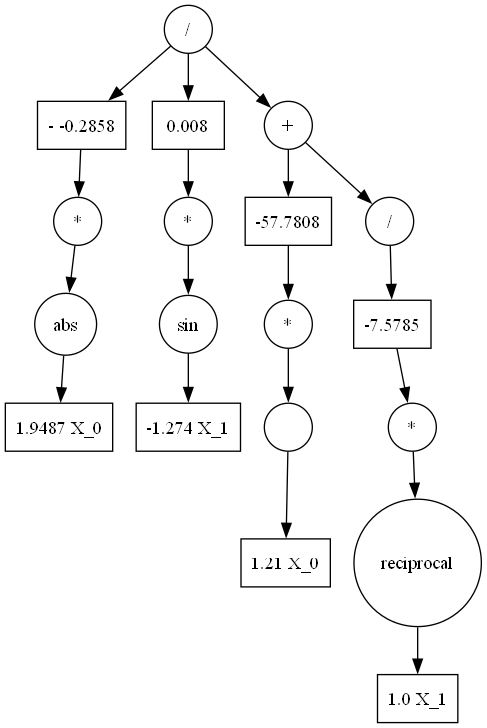

In [1431]:
from importlib import reload
import visualization
import graphviz
from IPython.display import Image, display
reload(visualization)

graph = visualization.create_formula_graph(w.genome)
img = graph.pipe("png")
display(Image(img))

In [1424]:
def compute_FX_FINAL(F,X, Y)->np.ndarray:
    
    # Number of terms
    num_terms = len(F) // 5

    # Pre-compute fixed F values
    coefficients = np.array([float(F[5 * i]) for i in range(num_terms)])
    variable_costs = np.array([float(F[2 + 5 * i]) for i in range(num_terms)])
    columns = np.array([int(F[3 + 5 * i].split("_")[1]) for i in range(num_terms)])
    operations = [F[1 + 5 * i] for i in range(num_terms)]
    operators = [F[4 + 5 * i] for i in range(num_terms)]

    # Map unary operations
    unary_funcs = [UNARY_OPERATIONS[op] for op in operations]

    # Extract the specific columns from X and apply variable costs
    X_selected = X[columns, :]  # Shape: (num_terms, num_rows)
    X_transformed = X_selected * variable_costs[:, np.newaxis]  # Broadcasting

    # Apply unary functions (broadcasting over rows)
    for i, func in enumerate(unary_funcs):
        X_transformed[i, :] = func(X_transformed[i, :])

    # Multiply by coefficients
    T = coefficients[:, np.newaxis] * X_transformed  # Shape: (num_terms, num_rows)

    # Apply the operators
    Y_pred = np.zeros(X.shape[1])
    for i, op in enumerate(operators):
        if op == "+":
            Y_pred += T[i, :]
        elif op == "-":
            Y_pred -= T[i, :]
        elif op == "*":
            Y_pred *= T[i, :]
        elif op == "/":
            Y_pred /= np.where(T[i, :] != 0, T[i, :], 1)  # Avoid division by zero

    Y_pred = Y_pred
    # Metrics
    mse = compute_MSE(Y_pred, Y)
    diff_abs = np.abs(Y_pred) - np.abs(Y)
    increase = np.mean(diff_abs) < 0
    inc_dec_factor = np.mean(diff_abs)
    right_sign = np.all((Y_pred > 0) == (Y > 0))
    count_right_sign = np.sum((Y_pred > 0) == (Y > 0))

    return mse, increase, right_sign, Y_pred, count_right_sign

In [1425]:
mse, increase, right_sign, Y_pred, count_right_sign = compute_FX_FINAL(w.genome,X,Y)
print(count_right_sign)
print(mse)
for i in range(50):
    print(f"Pred: {Y_pred[i]}, Real: {Y[i]}")

5000
43521.8507686068
Pred: 9.603607439866536, Real: 4.886874543831234
Pred: 5.764619240917568, Real: 1.3625490324738976
Pred: 52.54233198935451, Real: 26.71109035017986
Pred: 5.300805156914113, Real: 1.814733881276463
Pred: 0.6281813864009516, Real: 2.123309347216992
Pred: 51.33766484489951, Real: 21.53280153867726
Pred: 4.213093821046072, Real: 1.4467375348412779
Pred: 4.0722881316647825, Real: 7.286492391823499
Pred: 12.037669094485837, Real: 1.474519879659885
Pred: 23.588288297989735, Real: 6.977184696414297
Pred: 0.6153554926297599, Real: 2.669594590349818
Pred: 9.207139002989653, Real: 1.3016481176729822
Pred: 5.702997858685701, Real: 1.9771869621737075
Pred: 2.997550778941323, Real: 1.5215510726837251
Pred: 36.07465908215049, Real: 12.692574244458322
Pred: 34.94460785561403, Real: 11.191916872235021
Pred: 2.2720239174450985, Real: 1.7749070044803938
Pred: 0.42331632956113496, Real: 3.7111853831377895
Pred: 5.60147996170524, Real: 4.9491773187402455
Pred: 53.0908464151553, Real: 

In [1426]:
UNARY_OPERATORS_WEIGHTS

[array([0.14544708, 0.17708726, 0.14818547, 0.14231246, 0.        ,
        0.        , 0.        , 0.11125108, 0.        , 0.12489826,
        0.15081838]),
 array([0.13287794, 0.17377059, 0.13276698, 0.1504408 , 0.        ,
        0.        , 0.        , 0.12972208, 0.        , 0.13122129,
        0.14920034])]

In [1427]:
BINARY_OPERATORS_WEIGHTS

[array([0.1284081 , 0.12017488, 0.23296139, 0.51845563]),
 array([0.19538738, 0.44176094, 0.25177698, 0.1110747 ])]

Text(0, 0.5, 'Count')

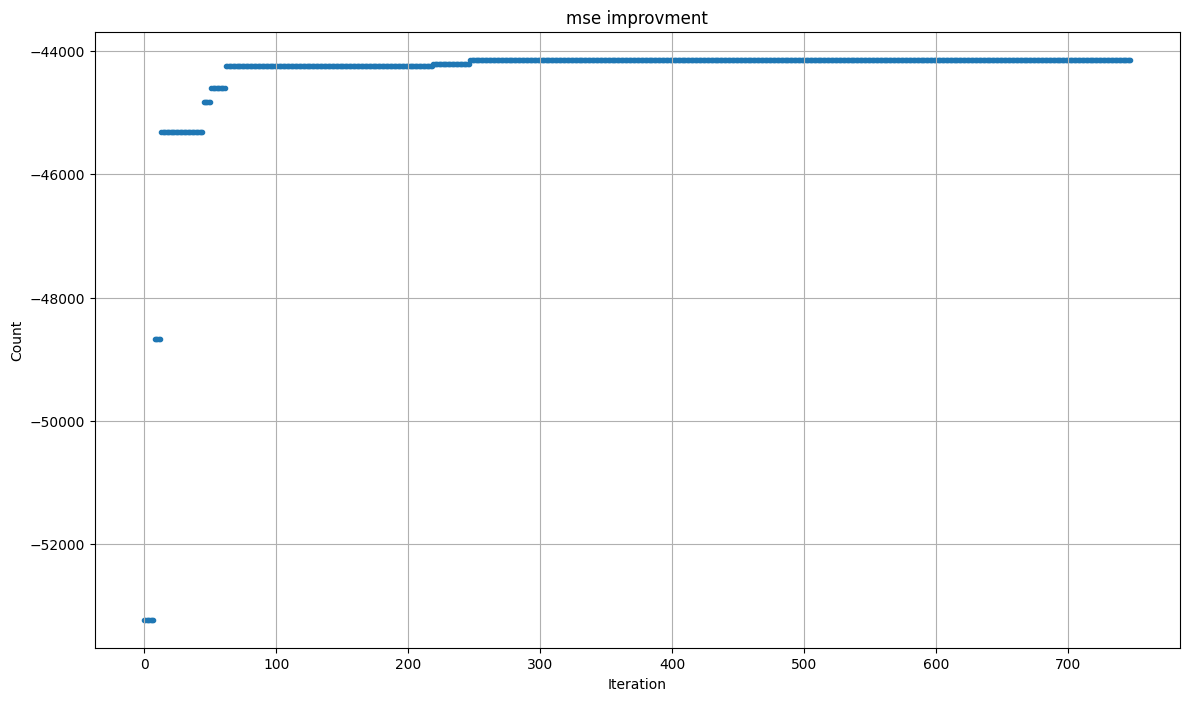

In [1428]:
#from itertools import accumulate
from matplotlib import pyplot as plt

#valid = [sol.fitness for sol in list(accumulate(history, max))]
#Array of all costs only
costs = [sol.fitness[1] for sol in history]
#Plot
plt.figure(figsize=(14, 8))             
plt.title("mse improvment")
plt.grid()

plt.scatter(range(len(costs)), costs, marker=".")

plt.xlabel('Iteration')
plt.ylabel('Count')